## Welcome to your notebook.


# Raster Analytics - Calculate Wildfire Landslide Risk

**Table of Contents**
  *import required libraries
  *get data
*create a burn severity map
  *visual assessment
  *quantitative assessment
*create a slope index map
*create the landslide risk map
  *reclassify landcover type to reflect vegetation stability
  *perform a weighted overlay analysis
  *generate a persistent analysis result via Raster Analysis
*summarize landslide risk by sub-basin
*conclusion

*In October 2017, wildfires ripped through Sonoma and Napa counties, devastating the surrounding communities.  Following these fires, the burn scars could cause further risk to public safety from a different kind of disaster, landslides.  Post-fire landslides are particularly hazardous because there is more erosion and weaker soil in burned areas without vegetation to anchor the topsoil.
*Groups handling rehabilitation, emergency planning and mitigation after a wildfire need to assess the vulnerability of the landscape to landslides.  In this notebook, we will provide local emergency management teams a summary of post-wildfire landslide risk, so officials can target mitigation efforts to the most vulnerable watershed basins.
*We will use imagery layers to assess landslide risk per watershed within the burn area.  We will create a landslide risk map and then summarize the landslide risk based on watershed sub-basins.  We will use raster function chains to derive a burn severity map, a topographic slope map, and a landcover index map.  These individual processing chains will be combined into one processing chain for distributed processing on the Raster Analytics server and then be summarized by watershed sub-basins.

# Import Required Libraries

#### Run this cell to connect to your GIS and get started:

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *

gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
arcgis.raster.analytics.is_supported(gis)

True

**Get Data**
*For this analysis we need the following datasets:
  *a Landsat 8 imagery for before (Before_L8)
  *a Landsat 8 imagery for after (After_L8) the wildfire
  *a DEM (digital elevation model) showing the elevation of the terrain
  *a NLCD (National Landcover Dataset) showing land use and predominant vegetation type
  *a watershed basin dataset
  
**Let's access the datasets from the GIS**

#### Now you are ready to start!

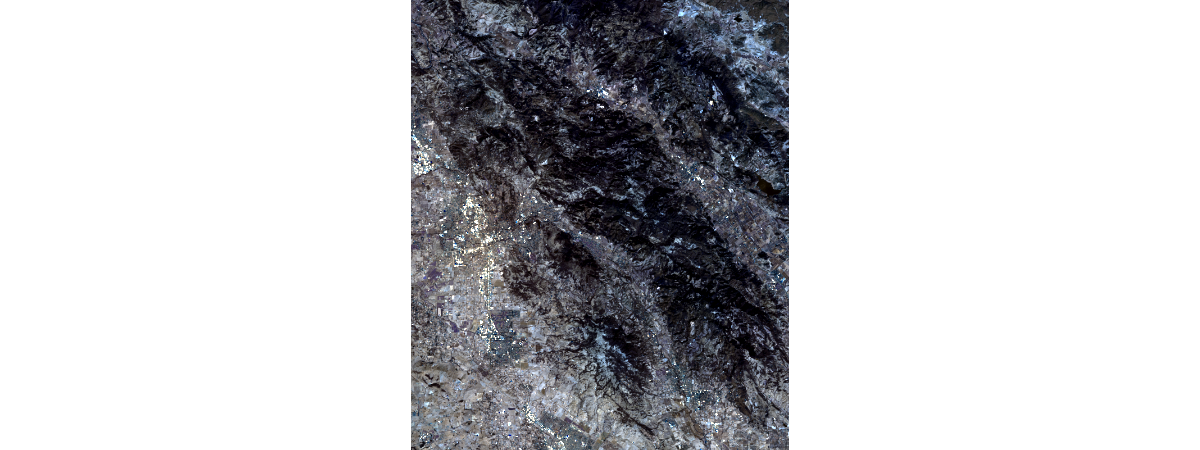

In [2]:
before_l8 = gis.content.search('title:Before_L8 owner:api_data_owner',
                               item_type = "Image Service",
                               outside_org=True)[0].layers[0]
after_l8 = gis.content.search('title:After_L8 owner:api_data_owner',
                              item_type = "Image Service",
                              outside_org=True)[0].layers[0]

before_l8

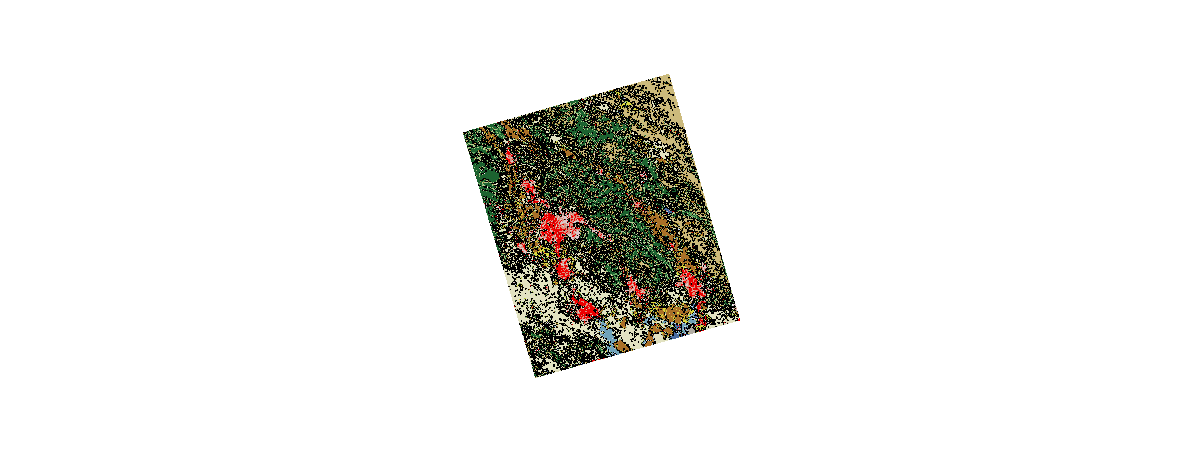

In [3]:
dem = gis.content.search('title:Sonoma_DEM owner:api_data_owner',
                         item_type = "Image Service",
                         outside_org=True)[0].layers[0]
nlcd = gis.content.search('title:Sonoma_NLCD2011 owner:api_data_owner',
                          item_type = "Image Service",
                          outside_org=True)[0].layers[0]
basins = gis.content.search('title:Sonoma_Basins owner:api_data_owner',
                            item_type = "Image Service",
                            outside_org=True)[0].layers[0]

# A preview of National Landcover Dataset layer
nlcd

# Create a Burn Severity Map
*To compare the burn scars on the Before and After Landsat imagery, we'll choose the multispectral bands 5, 3, 2 to be displayed.  The 5, 3, 2 band combination improves the visibility of fire and burn scars.  Healthy vegetation is shown in Bright Red, while stressed vegetation is displayed in Dull Red.  Nonvegetated features such as Bare and Urban Areas are displayed in various shades of Gray and Blue.

**Let's Apply the same bands combination to the Before_l8 and After_l8 layers**

In [4]:
infrared_before = extract_band(before_l8,
    band_names = ['sr_band5','sr_band3','sr_band2'])
infrared_after = extract_band(after_l8,
    band_names = ['sr_band5','sr_band3','sr_band2'])

**Visual Assessment**
*To help visually compare the burn effects, we create 2 maps and load the extracted bands of Before and After imagery - below


In [5]:
# Create two maps to compare before and after imageries side by side
map1 = gis.map(location='-122.58, 38.45', zoomlevel=10)
map2 = gis.map(location='-122.58, 38.45', zoomlevel=10)
map1.layout = Layout(flex='1 1', height='500px', padding='10px')
map2.layout = Layout(flex='1 1', height='500px', padding='10px')
map1.add_layer(infrared_before)
map2.add_layer(infrared_after)
box = HBox([map1, map2])
box

# Quantitative Assessment
**Normalized Burn Ratio (NBR)**
*can be used to delineate the burned areas and identify the severity of the fire.  The formula for NBR is very similar to that of NDVI except that it uses near-infrared band 5 and the short-wave infrared band 7.
*Source: http://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:normalized_burn_ratio


In [6]:
# Calculate before/after NBR indices and their difference
nbr_prefire  = band_arithmetic(before_l8,
                               band_indexes = "(b5 - b7) / (b5 + b7)")
nbr_postfire = band_arithmetic(after_l8,
                               band_indexes = "(b5 - b7) / (b5 + b7)")

nbr_diff = nbr_prefire - nbr_postfire

In [7]:
# Use Remap function to reclassify the NBR difference score to 1-5
nbr_diff_remap = remap(nbr_diff,
                       input_ranges=[-2.0,  0.1,  # Regrowth and Unburned
                                     0.1, 0.27,   # Low Severity burn
                                     0.27, 0.44,  # Medium Severity burn
                                     0.44, 0.66,  # Moderate Severity
                                     0.66, 2.00], # High Severity
                       output_values=[1, 2, 3, 4, 5], 
                       astype='u8')

# Create a colormap to show reclassified NBR indices with different color
burn_severity = colormap(nbr_diff_remap, 
                        colormap=[[1, 56, 168, 0], [2, 141, 212, 0], 
                                  [3, 255, 255, 0], [4, 255, 128, 0], 
                                  [5, 255, 0, 0]])

**To view the raster function chain visually, we install "graphviz" Python library**

In [8]:
! conda install graphviz -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.4.26  |       h06a4308_0         124 KB  defaults
    certifi-2022.6.15          |   py37h06a4308_0         153 KB  defaults
    openssl-1.1.1q             |       h7f8727e_0         2.5 MB  defaults
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following packages will be UPDATED:

  ca-certificates                     2021.10.26-h06a4308_2 --> 2022.4.26-h06a4308_0
  certifi                          2021.10.8-py37h06a4308_2 --> 20

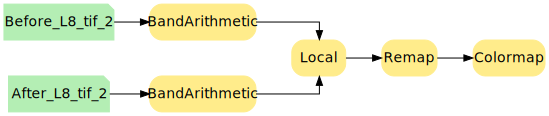

In [9]:
# Overview of what raster functions have been applied to 
# create burn_serverity layer
burn_severity.draw_graph()

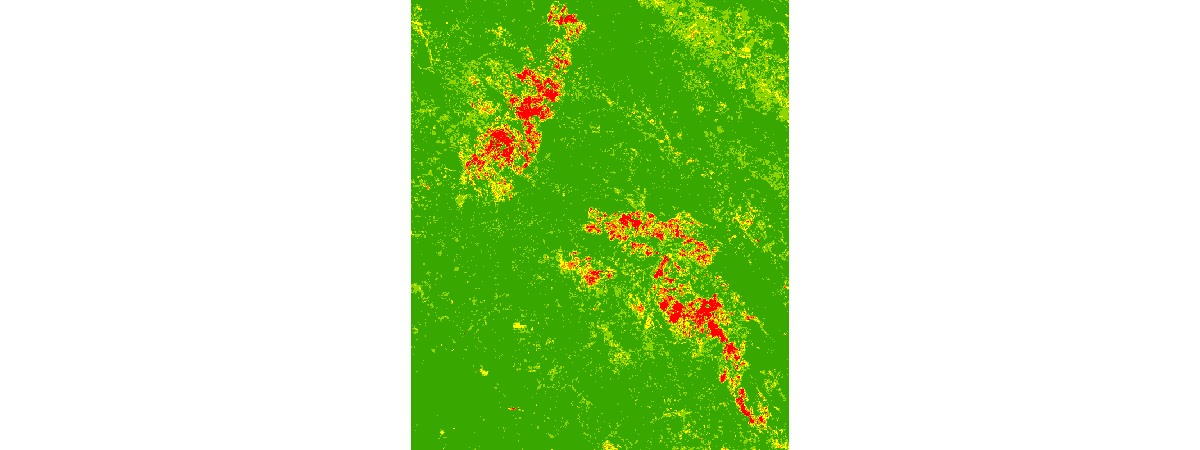

In [10]:
# Visualize burnt areas
burn_severity

*So far, we have computed the NBR on images from before and after the burn, and computed the NBR difference to identify places that have suffered the fire.  We've normalized the values to match a burn severity index, and applied a color map that brings out the extent of fire damage, seen in the image above.
*In the next section, we will use the quantitative burn severity image, the DEM, the NLCD, and the watershed basin dataset to predict places that are at a high risk for landslides.

# Create a Slope Index Map

*Before we can calculate a landslide risk map, we need to create a slope map.  This is a critical layer in determining land stability.  Slope steepness is drived from a DEM.  The steeper the slope, the more prone it is to slipping, especially during a rainfall event after stabilizing vegetation has been burned away.
**Let's calculate Slope, Reclassify Slope Values, and Assign Color Scheme in one raster function chain**

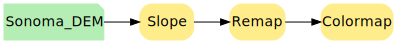

In [11]:
# Create slope index layer with a raster function chain
slope_index = colormap(remap(slope(dem),
                             input_ranges=[0,  5,  # Flat
                                           5, 15,  # Low
                                           15, 25,  # Moderate
                                           25, 35,  # Steep
                                           35, 91], # Very Steep
                             output_values=[1, 2, 3, 4, 5], 
                             astype='u8'),
                       colormap=[[1, 56, 168, 0], [2, 141, 212, 0], 
                                 [3, 255, 255, 0], [4, 255, 128, 0], 
                                 [5, 255, 0, 0]])

# Overview of what raster functions have been applied to 
# create slope_index layer
slope_index.draw_graph()

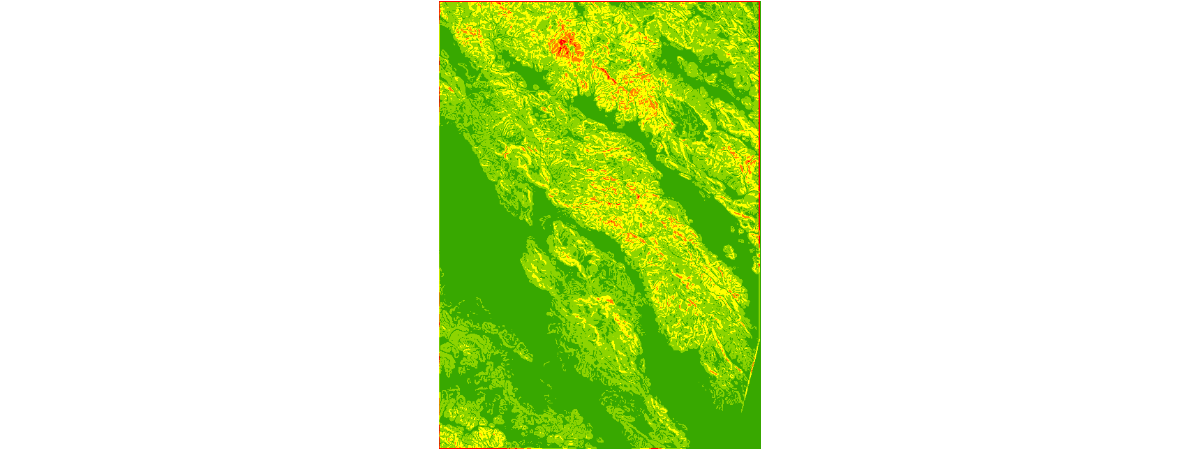

In [12]:
# Visualize slope index layer
slope_index

# Create the Landslide Risk Map
*The landslide risk calculation combines the 2 variables you just worked with: Burn Severity and Slope.  It also includes landcover, which is also important to landslide risk.  Vegetation stabilizes slopes via root systems.  Wildfire can wipe out much of stabilizing vegetation.  Some types of vegetation have adapted to wildfire, such as pieces of chaparral, which have root systems that are especially deep underground to survive fires.
*In this section, we will first Reclassify Landcover into 5 categories depending on its stabilizing effect on slopes.  Then we'll perform a Weighted Overlay Analysis based on the following 3 factors to determine the landslide risk in the study area;
  *Burn Severity (less severely burned areas have lower landslide risk)
  *Slope (lower slope areas have lower landslide risk)
  *Stability Index(higher vegetation-stabilized areas have lower landslide risk)
  
*The weighted overlay is a standard GIS analysis technique often used for solving multi-criteria problems such as generating surfaces representing site suitability and travel cost.  Weighted overlay is used when a number of factors of varying importance should be considered to arrive at a final decision.

**Let's Reclassify Landcover Type to reflect vegetation stability**

In [13]:
# Remap landcover to derive values for vegetation stability
stability_index = remap(nlcd,
                        input_ranges=[0,  12, 
                                      21, 23, 
                                      23, 23, 
                                      24, 31, 
                                      31, 44,
                                      52, 52,
                                      71, 71,
                                      81, 81,
                                      82, 82,
                                      90, 95], 
                        output_values=[1, 3, 4, 5, 1, 3, 4, 3, 4, 2], 
                        # 1: very stable 2: stable 3: moderate 
                        # 4: unstable 5: very unstable
                        astype='u8')

# Perform a Weighted Overlay Analysis
**Step 1: Normalize the input datasets**
  *We have already used the "remap" function to normalize all the input datasets (burn_severity, slope_index, and stability_index) to a common scale of 1-5.  Locations assigned a value of "1" are considered to carry the Least Landslide Risk (e.g. stabilized slopes with low burn severity), while locations assigned the value of "5" are considered to carry a High Risk of Landslide (e.g. the steepest slopes and most burned areas).
**Step 2: Assign weights to the normalized input datasets based on their relative importance**
  *Here we assign "weights" to the normalized inputs by multiplying each of them by a value between 0.0 and 1.0.  The sum of the weight values must equal 1.0.
  *We use Map Algebra to apply the following weights to the criteria of this study:
    *Burn Severity: 30%
    *Slope: 55%
    *Stability Index: 15%
  *We'll multiply each raster in the step below to produce the final result
**Step 3: Calculate the Sum of the Weighted Input Datasets**
  *We calculate the final result of the weighted overlay by calculating the sum of the weighted input datasets.  Areas that are most likely to have landslides according to our multi-criteria based on burn severity, slope, and stability index are assigned a value of 5 and displayed in Red.  Areas that are least likely to have landslides are assigned a value of 1 and displayed in Green.

In [14]:
landslide_risk = colormap(# burn severity
                         0.30 * burn_severity
                         + 
                         # Slope index
                         0.55 * slope_index
                         +
                         # Stability index
                         0.15 * stability_index,
                         colormap=[[1, 56, 168, 0], [2, 141, 212, 0], 
                                   [3, 255, 255, 0], [4, 255, 128, 0], 
                                   [5, 255, 0, 0]],
                         astype='u8')

In [15]:
# Create three maps to compare before and after imageries 
# and the landslide risk map side by side
map1 = gis.map(location='-122.58, 38.45', zoomlevel=15)
map2 = gis.map(location='-122.58, 38.45', zoomlevel=15)
map3 = gis.map(location='-122.58, 38.45', zoomlevel=15)
map1.layout = Layout(flex='1 1', height='500px', padding='5px')
map2.layout = Layout(flex='1 1', height='500px', padding='5px')
map3.layout = Layout(flex='1 1', height='500px', padding='5px')
map1.add_layer(infrared_before)
map2.add_layer(infrared_after)
map3.add_layer(landslide_risk)
box = HBox([map1, map2, map3])
box

# Generate a Persistent Analysis Result via Raster Analysis
*Raster functions perform their calculations on-the-fly.  Since no intermediate datasets are created, processes can be applied quickly, as opposed to the time it would take to create a processed file on disk.
*ArcGIS Enterprise can perform distributed server-based processing on imagery and raster data.  By using Raster Analysis on an ArcGIS Image Server federated with your ArcGIS Enterprise portal, you can generate persistent analysis results from raster functions using distributed processing.
*This technology enables you to boost the performance of raster processing by processing data across multiple cores, even at full resolution and full extent.  The results of this processing are accessed in a web imagery layer hosted in the ArcGIS Enterprise portal.

*To save the landslide risk layer as a persistent Imagery Layer on your GIS, call the "save()" method on the layer.  This invokes the distributed raster processing, applies the chain of raster functions at full resolution, and serves the result as a new Imagery Layer.

In [17]:
# Save the result as an image service
landslide_risk_persistent = landslide_risk.save("Sonoma_Landslide_Risk2")

In [18]:
# Share it to the public
landslide_risk_persistent.share(everyone=True, org=True)

{'results': [{'itemId': '2725afe5ed184535a50e415dc958bc6e',
   'success': True,
   'notSharedWith': []}]}

# Summarize Landslide Risk by Sub-Basin
*Although the landslide risk map is useful, you may want to go further to break down the areas that are most at risk.  Because landslide risk is impacted by precipitation patterns and watershed characteristics, we'll summarize risk by watershed basins within the study area.  We'll use the landslide risk map produced in the previous step to summarize risk per sub-basin.

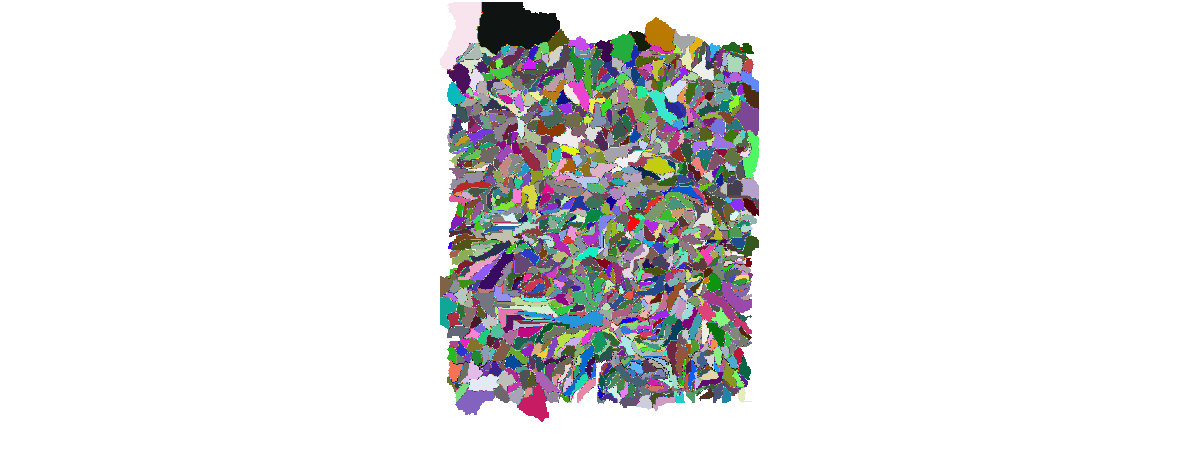

In [19]:
# Preview of the sub-basin layer
basins

*Now we will use a global raster function called Zonal Statistics to calculate statistics on values of a raster within the zones of another dataset.  You will need the following parameters:
  *"in-zone_data:" dataset that defines the zones
  *"zone_field:" Field that holds the values that define each zone
  *"in_value_raster:" Raster that contains the values on which to calculate a statistic
  *"ignore_no_data:" Denotes whether "NoData" values in the Value Raster will influence the results of the zone that they fall within.
  *"statistics"type:" The Statistic to be calculated.  Can take any of the following values: "mean, majority, maximum, median, minimum, minority, range, STD, Sum, variety"

In [21]:
%%time
# Run global raster function and generate a persistent result in portal
landslide_risk_per_basin = gbl.zonal_statistics(in_zone_data = basins, 
                                        zone_field='Value', 
                                        in_value_raster=landslide_risk, 
                                        ignore_nodata=True, 
                                        statistics_type='MEAN')

landslide_risk_per_basin_saved = landslide_risk_per_basin.save(
                                        "Landslide_Risk_Per_Basin2")

CPU times: user 92.5 ms, sys: 5.64 ms, total: 98.1 ms
Wall time: 18.9 s


In [22]:
# Save the final result as a web map
landslide_by_basin_map = gis.map('-122.58, 38.45', 10)

landslide_by_basin_map.add_layer(landslide_risk_per_basin_saved, 
                options={'title':'Landslide risk aggregated per basin'})
landslide_by_basin_map.add_layer(landslide_risk, 
                options={'title':'Landslide risk',
                         'visibility':False})
landslide_by_basin_map.add_layer(infrared_before,
                options={'title':'Pre fire satellite imagery',
                         'visibility':False})
landslide_by_basin_map.add_layer(infrared_after,
                options={'title':'Post fire satellite imagery',
                         'visibility':False})
landslide_by_basin_map.add_layer(dem,
                options={'title':'Elevation layer used to derive slope',
                         'visibility':False})
landslide_by_basin_map.add_layer(nlcd,
                options={'title':'National LandCover Dataset',
                         'visibility':False})
landslide_by_basin_map.add_layer(basins,
                options={'title':'Watershed basins',
                         'visibility':False})

landslide_by_basin_map.add_layer(infrared_after)
landslide_by_basin_map.save({'title':'Landslide risk map',
                            'tags':['landslide','analysis','forest fire'],
                            'snippet':'Landslide risk map per basin.'})

<Item title:"Landslide risk map" type:Web Map owner:arcgis_python>

*We have saved a web map containing the landslide risk per basin, overall landslide risk predictions, and all other layers used to derive the output.  This map can easily be shared with local emergency management agencies.

# Conclusion
*In this notebook example, we used raster function chains to create a burn severity map, slope index map, and landcover index map.  We then created a landslide risk map, and summarized risk by watershed sub-basin.  We used Raster Functions to represent our model as Python functions, chained them together and rendered them on the fly.  Finally, to save them as persistent results on the GIS, we used the power of distributed raster processing available on the Image Server and created output landslide risk Imagery Layers.